In [175]:
import pulp
import numpy as np
import time
import matplotlib.pyplot as plt

import sys
sys.path.append("../src/data")
import read_instances

## flowshop

defining the problem: a set of jobs must be processed on a series of machines in a specific order. Each job has the same processing sequence across machines.

- given:

    - n jobs
    - m machines
    - matrix of processing times: $P[i][j]$ represents the processing time of job i on machine j

- decision variables:

    - $C_{i,j}$: completion time of job i on machine j
    - $x_{i,k}$: binary variable indicating whether job i is assigned to position k
    - M: large constant (used for big-M constraints)

- objective:

    - minimize the makespan $C_{\max}$ (the total completion time of all jobs)

- constraints:

    - each job is assigned exactly once / each job is scheduled once: $$\sum_{k=1}^{n} x_{i,k} = 1, \quad \forall i \in \{1, \dots, n\}$$

    - each position is assigned to only one job / each position gets only one job: $$\sum_{i=1}^{n} x_{i,k} = 1, \quad \forall k \in \{1, \dots, n\}$$

    - first machine processing time constraint: $$C_{i,1} \geq p_{1,i}, \quad \forall i \in \{1, \dots, n\}$$

    - sequential processing on machines: $$C_{i,j} \geq C_{i,j-1} + p_{j,i}, \quad \forall i \in \{1, \dots, n\}, \forall j \in \{2, \dots, m\}$$

    - job precedence constraint (Big-M formulation) / no job starts before the previous one finishes: $$C_{i,j} \geq C_{i-1,j} + p_{j,i} - M(1 - x_{i,k}), \quad \forall i \in \{2, \dots, n\}, \forall j \in \{1, \dots, m\}, \forall k \in \{1, \dots, n\}$$

    - makespan constraint: $$C_{\max} \geq C_{i,m}, \quad \forall i \in \{1, \dots, n\}$$


In [195]:
def flowshop_model(num_jobs: int, num_machines: int, processing_times: list[list[int]]):
    
    if (len(processing_times), len(processing_times[0])) != (num_machines, num_jobs):
        raise ValueError("The dimensions of the processing_times matrix do not match the number of jobs and machines.")

    model = pulp.LpProblem("FlowShop", pulp.LpMinimize)

    # Decision Variables
    C = [[pulp.LpVariable(f"C_{i}_{j}", lowBound=0) for j in range(num_machines)] for i in range(num_jobs)]
    x = [[pulp.LpVariable(f"x_{i}_{k}", cat=pulp.LpBinary) for k in range(num_jobs)] for i in range(num_jobs)]
    C_max = pulp.LpVariable("C_max", lowBound=0)  # Makespan

    # Objective Function: Minimize the makespan
    model += C_max

    # Constraints
    # Each job is scheduled exactly once
    for i in range(num_jobs):
        model += pulp.lpSum(x[i][k] for k in range(num_jobs)) == 1

    # Each position gets only one job
    for k in range(num_jobs):
        model += pulp.lpSum(x[i][k] for i in range(num_jobs)) == 1

    # # Processing order constraints within each job
    # for i in range(num_jobs):
    #     model += C[i][0] >= processing_times[0][i]  # First machine constraint
    #     for j in range(1, num_machines):
    #         model += C[i][j] >= C[i][j-1] + processing_times[j][i]  # Sequential processing

    # # Enforce job precedence (no job can start before the previous one finishes)
    # for i in range(1, num_jobs):  # Start from the second job
    #     for j in range(num_machines):
    #         model += C[i][j] >= C[i-1][j] + processing_times[j][i]  # Ensure correct job order
    
    # Processing order constraints
    for i in range(num_jobs):
        model += C[i][0] >= processing_times[0][i]  # First machine constraint

        for j in range(1, num_machines):
            model += C[i][j] >= C[i][j-1] + processing_times[j][i]  # Sequential processing


    # No job starts before the previous one finishes
    M = 10_000  # Large constant for Big-M constraint
    for i in range(num_jobs):
        for k in range(num_jobs):
            for j in range(num_machines):
                if i > 0:  # Ensure precedence
                    model += C[i][j] >= C[i-1][j] + processing_times[j][i] - M * (1 - x[i][k])
    
    # Makespan constraints
    for i in range(num_jobs):
        model += C_max >= C[i][-1]

    return model, C, x, C_max

In [193]:
file_path = "../data/flowshop_tai20_5.txt"
flowshop = read_instances.FlowShop(file_path)

flowshop_data = flowshop.data[2]

print(flowshop_data)

{'nb_jobs': 20, 'nb_machines': 5, 'seed': 1866992158, 'upper_bound': 1081, 'lower_bound': 1073, 'times': [[77, 94, 9, 57, 29, 79, 55, 73, 65, 86, 25, 39, 76, 24, 38, 5, 91, 29, 22, 27], [39, 31, 46, 18, 93, 58, 85, 58, 97, 10, 79, 93, 2, 87, 17, 18, 10, 50, 8, 26], [14, 21, 15, 10, 85, 46, 42, 18, 36, 2, 44, 89, 6, 3, 1, 43, 81, 57, 76, 59], [11, 2, 36, 30, 89, 10, 88, 22, 31, 9, 43, 91, 26, 3, 75, 99, 63, 83, 70, 84], [83, 13, 84, 46, 20, 33, 74, 42, 33, 71, 32, 48, 42, 99, 7, 54, 8, 73, 30, 75]]}


In [196]:
model, C, x, C_max = flowshop_model(
    flowshop_data["nb_jobs"],
    flowshop_data["nb_machines"],
    flowshop_data["times"]
)
seed = str(flowshop_data["seed"])

solver = pulp.PULP_CBC_CMD(msg=False, timeLimit=120, options=[f"randomSeed {seed}"])
print(solver.toDict())

start_time = time.time()

status = model.solve(solver)
objective = pulp.value(model.objective)

runtime = time.time() - start_time

{'solver': 'PULP_CBC_CMD', 'mip': True, 'msg': False, 'keepFiles': False, 'timeLimit': 120, 'options': ['randomSeed 1866992158'], 'warmStart': False, 'timeMode': 'elapsed'}


In [197]:
print("Optimal Job Schedule:")
optimal_schedule = [(i, k) for i in range(flowshop_data["nb_jobs"]) for k in range(flowshop_data["nb_jobs"]) if x[i][k].varValue == 1]
for job, position in optimal_schedule:
    print(f"Job {job+1} assigned to position {position}")

Optimal Job Schedule:
Job 1 assigned to position 7
Job 2 assigned to position 4
Job 3 assigned to position 17
Job 4 assigned to position 15
Job 5 assigned to position 9
Job 6 assigned to position 10
Job 7 assigned to position 3
Job 8 assigned to position 0
Job 9 assigned to position 5
Job 10 assigned to position 19
Job 11 assigned to position 14
Job 12 assigned to position 12
Job 13 assigned to position 6
Job 14 assigned to position 13
Job 15 assigned to position 16
Job 16 assigned to position 2
Job 17 assigned to position 1
Job 18 assigned to position 18
Job 19 assigned to position 11
Job 20 assigned to position 8


In [198]:
print(f"Status: {model.status}, Objective: {objective}, Runtime: {runtime:.2f} seconds")
print(f"Optimal Makespan: {pulp.value(C_max)}")

Status: 1, Objective: 1597.0, Runtime: 120.08 seconds
Optimal Makespan: 1597.0


In [199]:
upper_bound = flowshop_data["upper_bound"]
lower_bound = flowshop_data["lower_bound"]
solution_makespan = pulp.value(C_max)

if solution_makespan <= lower_bound:
    print("Optimal solution found!")
elif lower_bound < solution_makespan <= upper_bound:
    print(f"Feasible solution: {solution_makespan}, but may be improved.")
else:
    print(f"Solution {solution_makespan} is above the known upper bound!")

# Compute the performance gap
gap = ((solution_makespan - lower_bound) / (upper_bound - lower_bound)) * 100
print(f"Performance Gap: {gap:.2f}%")

Solution 1597.0 is above the known upper bound!
Performance Gap: 6550.00%


/tmp/ipykernel_44418/129274244.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_jobs)  # Get distinct colors for jobs


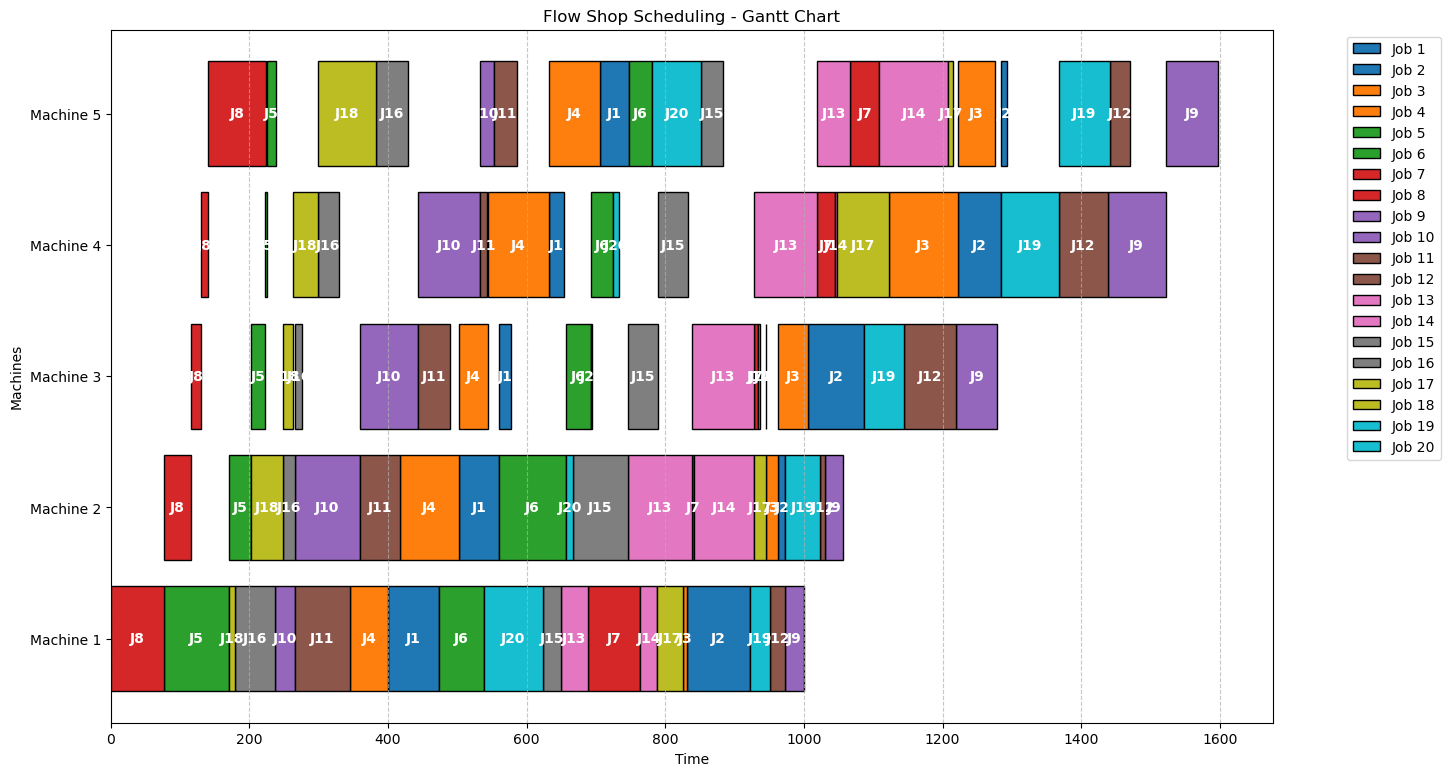

In [200]:

fig, ax = plt.subplots(figsize=(15, 9))

num_jobs = flowshop_data["nb_jobs"]
num_machines = flowshop_data["nb_machines"]
processing_times = flowshop_data["times"]

colors = plt.cm.get_cmap("tab10", num_jobs)  # Get distinct colors for jobs

optimal_schedule = [(i, k) for i in range(flowshop_data["nb_jobs"]) for k in range(flowshop_data["nb_jobs"]) if x[i][k].varValue == 1]

sorted_jobs = sorted(optimal_schedule, key=lambda x: x[1])  # Sort by position

for job, position in sorted_jobs:  
    for j in range(num_machines):
        end_time = C[job][j].varValue  # Completion time
        start_time = end_time - processing_times[j][job]  # Compute correct start time
        
        ax.barh(y=f"Machine {j+1}", width=processing_times[j][job], left=start_time, 
                color=colors(position), edgecolor='black', label=f"Job {position+1}" if j == 0 else "")

        # Add text inside bars
        ax.text(start_time + (processing_times[j][job] / 2), j, f"J{position+1}", 
                ha='center', va='center', color='white', fontsize=10, fontweight='bold')

# Labels and title
ax.set_xlabel("Time")
ax.set_ylabel("Machines")
ax.set_title("Flow Shop Scheduling - Gantt Chart")

# Ensure machines remain in correct order
ax.set_yticks(range(num_machines))
ax.set_yticklabels([f"Machine {j+1}" for j in range(num_machines)])

ax.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()